##Setup Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                           accuracy_score, roc_auc_score, classification_report,
                           confusion_matrix, roc_curve, auc)
import seaborn as sns
import random

# Set random seeds for reproducibility
SEED = 37
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define directory paths
SAVE_DIR = '/content/drive/MyDrive/DLproj1/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Loading and Preprocessing

- Loaded ERA5 predictor data (`train_X`, `test_X`) and SPEI target data (`train_y`, `test_y`) as NumPy arrays from Drive. Data was generated via API pipelines (ERA5 + SPEI); pipeline implementation and provenance tracked in project GitHub repository.

- Training period covers **1999–2001**, while **2002** serves as the held-out test set.

- Input sequences were structured as five-dimensional tensors of shape **(31, 20, 20, 13)** — representing **31 consecutive daily time steps**, a **20×20 spatial grid**, and **13 meteorological input channels**. This structure preserves both spatial heterogeneity and temporal dynamics critical for drought modeling.

- Confirmed SPEI target data was pre-normalized (mean ≈ 0, std ≈ 1) in its NetCDF source to ensure statistical consistency across time and space.

- Applied `preprocess_data()` to handle missing values:
  - Replaced fill values (`-9999`) with `NaN`.
  - Applied linear interpolation along the time axis to fill gaps, maintaining temporal continuity.

- Standardized ERA5 input features using `StandardScaler` fit on the training set; the fitted scaler was applied consistently to the test set to prevent data leakage.
  → SPEI target values were left unscaled, as normalization was already performed upstream.

- Validated processed data integrity:
  - No remaining `NaN` values post-processing.
  - Confirmed all tensors conformed to expected shapes and value ranges.


In [3]:
# Load data
def load_data(path):
    data = np.load(path)
    print(f"Loaded {path} with shape: {data.shape}")
    return data

# Load all datasets
print("Loading data...")
train_X = load_data(f'{SAVE_DIR}/raw_train_X_combined.npy')
train_y = load_data(f'{SAVE_DIR}/raw_train_y_combined.npy')
test_X = load_data(f'{SAVE_DIR}/raw_test_X.npy')
test_y = load_data(f'{SAVE_DIR}/raw_test_y.npy')

Loading data...
Loaded /content/drive/MyDrive/DLproj1//raw_train_X_combined.npy with shape: (594, 31, 20, 20, 13)
Loaded /content/drive/MyDrive/DLproj1//raw_train_y_combined.npy with shape: (594, 31, 20, 20, 1)
Loaded /content/drive/MyDrive/DLproj1//raw_test_X.npy with shape: (198, 31, 20, 20, 13)
Loaded /content/drive/MyDrive/DLproj1//raw_test_y.npy with shape: (198, 31, 20, 20, 1)


In [4]:
# Data Cleaning

#Checking to see if the SPEI data is already normalised
import xarray as xr
# Load the NetCDF file
ds_spei = xr.open_dataset(f'{SAVE_DIR}/spei01.nc')

# Extract the SPEI variable
spei_data = ds_spei['spei'].values
# Compute statistics (ignoring NaNs)
spei_mean = np.nanmean(spei_data)
spei_std = np.nanstd(spei_data)

print(f"SPEI mean: {spei_mean:.2f}, std: {spei_std:.2f}")

# Data preprocessing
def preprocess_data(data, fill_value=-9999):
    data = data.copy()                                     # Create a copy of the input data
    data[data == fill_value] = np.nan                     # Replace specified fill values with NaN
    df = pd.DataFrame(data.reshape(-1, data.shape[-1]))   # Reshape the data to a 2D DataFrame
    df.interpolate(method='linear', axis=0, inplace=True) # Perform linear interpolation along the first axis (time) to fill NaNs in place
    return df.values.reshape(data.shape)                   # Reshape the interpolated data back to its original shape

# Apply preprocessing to training and testing sets
print("\nPreprocessing data...")
train_X = preprocess_data(train_X)
train_y = preprocess_data(train_y)
test_X = preprocess_data(test_X)
test_y = preprocess_data(test_y)

# Feature standardization
def standardize_data(data, scaler=None):
    original_shape = data.shape                           # Store the original shape of the input data
    data_flat = data.reshape(-1, original_shape[-1])      # Flatten the data while preserving the last dimension (features)

    if scaler is None:
        scaler = StandardScaler()                       # Initialize a StandardScaler if no scaler is provided
        scaled_data = scaler.fit_transform(data_flat)    # Fit the scaler on the flattened data and transform it
    else:
        scaled_data = scaler.transform(data_flat)        # Use the provided scaler to transform the flattened data

    return scaled_data.reshape(original_shape), scaler    # Reshape the standardized data back to its original shape and return the scaler

# Apply standardization to feature datasets
print("\nStandardizing feature data...")
train_X_std, scaler_X = standardize_data(train_X)
test_X_std, _ = standardize_data(test_X, scaler_X)       # Use the scaler fitted on the training data to transform the test data

# Skip standardization for target variables (SPEI)
train_y_std = train_y                                     # Keep the original preprocessed SPEI values as they are already normalized
test_y_std = test_y                                       # Keep the original preprocessed SPEI values as they are already normalized

# Data shape and quality validation
def validate_shapes(*datasets):
    for data in datasets:
        print(f"Shape: {data.shape}, NaNs: {np.isnan(data).sum()}, Min: {np.nanmin(data)}, Max: {np.nanmax(data)}") # Print the shape, number of NaNs, minimum, and maximum values of each dataset

# Validate the processed training and testing data
print("\nValidating training data:")
validate_shapes(train_X_std, train_y_std)
print("\nValidating test data:")
validate_shapes(test_X_std, test_y_std)

SPEI mean: 0.00, std: 1.00

Preprocessing data...

Standardizing feature data...

Validating training data:
Shape: (594, 31, 20, 20, 13), NaNs: 0, Min: -7.349778175354004, Max: 3.4755847454071045
Shape: (594, 31, 20, 20, 1), NaNs: 0, Min: -4.7372965812683105, Max: 2.982602119445801

Validating test data:
Shape: (198, 31, 20, 20, 13), NaNs: 0, Min: -7.349778175354004, Max: 3.349893093109131
Shape: (198, 31, 20, 20, 1), NaNs: 0, Min: -5.468786239624023, Max: 2.4230692386627197


# VAE Model

## Model Architecture

- Developed a **Variational Autoencoder (VAE)** tailored for reconstructing and forecasting SPEI values from daily ERA5 reanalysis data over Australia.

- Chose a VAE structure to model the probabilistic latent space of drought-related conditions, enabling both reconstruction and generative modeling of plausible future scenarios under uncertainty — a key advantage for drought risk applications.

- **Encoder** design:
  - Applied **TimeDistributed Conv2D** layers over each time step to capture local spatial patterns (e.g. pressure, humidity anomalies) across the 20×20 grid.
  - Incorporated **MaxPooling** and **Dropout** to control overfitting and improve generalization, particularly important given the modest spatial grid size and temporal dependency.
  - Flattened spatial dimensions per timestep and fed sequences into an **LSTM** to model temporal dependencies and multi-day evolution of drought indicators.
  - Produced latent variables: `z_mean` and `z_log_var`, representing the posterior distribution parameters for the latent drought state.

- **Decoder** design:
  - Projected latent variables to a higher-dimensional spatial map.
  - Used **Conv2DTranspose** layers for upsampling, restoring spatial resolution while reconstructing meteorological patterns conditioned on the latent drought state.
  - Added a **time dimension** and applied **UpSampling3D** to match the original temporal sequence length.
  - Final **Conv3D** layer outputs continuous SPEI estimates, scaled via `tanh` activation to match the [-3, 3] climatological SPEI range.

- Custom `train_step` and `test_step` methods:
  - Explicitly computed **reconstruction loss (MSE)** and **KL divergence**, combined via a weighted sum.
  - Included additional tracked metrics: MSE, MAE for output accuracy monitoring.

- Verification:
  - Confirmed end-to-end tensor shapes: **(1, 31, 20, 20, 13)** input → **(1, 32)** latent → **(1, 31, 20, 20, 1)** output.
  - Validated non-zero encoder gradients to ensure trainability and proper gradient flow through spatial-temporal layers.
  - Observed healthy gradient norms (range ≈0.07–3.4), confirming stable backpropagation and well-conditioned optimization dynamics.


- Overall, this architecture balances spatial feature extraction, temporal sequence modeling, and uncertainty quantification — well-suited to capturing the complex, dynamic, and spatially variable nature of drought processes.


In [5]:
# =================== MODEL ARCHITECTURE ===================
class DroughtVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # Define the sampling layer using the reparameterization trick
        self.sampling = layers.Lambda(
            lambda args: args[0] + tf.exp(0.5 * args[1]) * tf.random.normal(tf.shape(args[0])),
            output_shape=lambda input_shape: input_shape[0]
        )

        # Initialize metrics to track loss and performance
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.mse_tracker = keras.metrics.MeanSquaredError(name="mse")
        self.mae_tracker = keras.metrics.MeanAbsoluteError(name="mae")

    @property
    def metrics(self):
        # Define the list of metrics the model will track
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.mse_tracker,
            self.mae_tracker
        ]

    def call(self, inputs):
        # Define the forward pass of the VAE
        z_mean, z_log_var = self.encoder(inputs) # Encode the input to get the mean and log variance of the latent space
        z = self.sampling([z_mean, z_log_var])    # Sample a point from the latent space using the reparameterization trick
        return self.decoder(z)                   # Decode the sampled latent point to reconstruct the output

    def train_step(self, data):
        # Define the training step for the VAE
        x, y = data

        with tf.GradientTape() as tape:
            # Perform the forward pass within a gradient tape to track operations for differentiation
            z_mean, z_log_var = self.encoder(x)
            z = self.sampling([z_mean, z_log_var])
            y_pred = self.decoder(z)

            # Calculate the reconstruction loss (L2 loss between true and predicted values)
            reconstruction_loss = tf.reduce_mean(tf.square(y - y_pred))
            # Calculate the KL divergence loss (measures the difference between the learned latent distribution and a standard Gaussian)
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # Calculate the total loss as the sum of reconstruction and KL losses
            total_loss = reconstruction_loss + 0.1 * kl_loss

        # Calculate gradients of the total loss with respect to the trainable weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        # Apply the gradients to update the model's trainable weights using the optimizer
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update the state of the metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.mse_tracker.update_state(y, y_pred)
        self.mae_tracker.update_state(y, y_pred)

        # Return a dictionary mapping metric names to their current results
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        # Define the testing step for the VAE
        x, y = data

        # Perform the forward pass
        z_mean, z_log_var = self.encoder(x)
        y_pred = self.decoder(z_mean)

        # Calculate the reconstruction loss and KL divergence loss
        reconstruction_loss = tf.reduce_mean(tf.square(y - y_pred))
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        total_loss = reconstruction_loss + 0.1 * kl_loss

        # Update the state of the metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.mse_tracker.update_state(y, y_pred)
        self.mae_tracker.update_state(y, y_pred)

        # Return a dictionary mapping metric names to their current results
        return {m.name: m.result() for m in self.metrics}


# Encoder Definition
latent_dim = 32
encoder_inputs = keras.Input(shape=(31, 20, 20, 13))
# Apply 2D convolution over the spatial dimensions at each time step
x = layers.TimeDistributed(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))(encoder_inputs)
# Apply 2D max pooling over the spatial dimensions at each time step
x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
# Apply dropout for regularization at each time step
x = layers.TimeDistributed(layers.Dropout(0.4))(x)
# Flatten the spatial dimensions at each time step
x = layers.TimeDistributed(layers.Flatten())(x)
# Apply LSTM to process the temporal sequence
x = layers.LSTM(64, dropout=0.3)(x)
# Output layer for the mean of the latent space
z_mean = layers.Dense(latent_dim)(x)
# Output layer for the log variance of the latent space
z_log_var = layers.Dense(latent_dim)(x)
# Define the encoder model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

# Decoder Definition
latent_inputs = keras.Input(shape=(latent_dim,))
# Project the latent vector to a higher dimensional space
x = layers.Dense(10*10*32, activation='relu')(latent_inputs)
# Reshape to a 2D feature map
x = layers.Reshape((10, 10, 32))(x)
# Apply transposed convolution to upsample
x = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
# Apply transposed convolution with stride to further upsample to 20x20
x = layers.Conv2DTranspose(16, (3,3), strides=2, activation='relu', padding='same')(x)
# Add a time dimension of 1
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(x)
# Upsample along the time dimension to match the input sequence length
x = layers.UpSampling3D(size=(31, 1, 1))(x)
# Apply 3D convolution to get the final output (scaling to [-3, 3] range)
decoder_outputs = layers.Conv3D(1, (3,3,3), padding='same', activation='tanh')(x) * 3
# Define the decoder model
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Combine into VAE
vae = DroughtVAE(encoder, decoder)


In [6]:
# =================== VERIFICATION CHECKS ===================
# Verify the input, latent, and output tensor shapes
sample_input = np.random.randn(1, 31, 20, 20, 13)
z_mean, z_log_var = encoder(sample_input)
sample_output = decoder(z_mean)
print(f"\nShape verification:")
print(f"Input shape: {sample_input.shape}")
print(f"Latent shape: {z_mean.shape}")
print(f"Output shape: {sample_output.shape}")

# Check for non-zero gradients in the encoder
print("\nGradient check:")
with tf.GradientTape() as tape:
    z_mean, z_log_var = encoder(sample_input)
    loss = tf.reduce_mean(z_log_var)      # Calculate a simple loss based on latent log variance
grads = tape.gradient(loss, encoder.trainable_variables) # Compute gradients of the loss with respect to encoder weights
print(f"Gradient norms: {[tf.norm(g).numpy() for g in grads if g is not None]}") # Display the L2 norms of the gradients


Shape verification:
Input shape: (1, 31, 20, 20, 13)
Latent shape: (1, 32)
Output shape: (1, 31, 20, 20, 1)

Gradient check:
Gradient norms: [np.float32(0.66564703), np.float32(0.13190971), np.float32(4.0240993), np.float32(0.2618184), np.float32(0.08375821), np.float32(0.63002837), np.float32(0.17677669)]


## Training and Evaluation Methodology

- **Data Split**:  
  The training dataset was split chronologically, with **80% for training** and **20% for validation**. This chronological split is crucial to maintain the temporal structure in time series data, ensuring that the model does not have access to future information when training, which would lead to data leakage.

- **Compilation and Optimizer**:  
  The model was compiled with the **Adam optimizer** and a **learning rate of 0.0001**. Adam is chosen for its adaptive learning rate, making it well-suited for the complex and potentially noisy gradient landscape in models like VAEs. We used **Mean Absolute Error (MAE)** as the metric to track, as it directly measures the reconstruction error in continuous SPEI values.

- **Callbacks**:  
  - **EarlyStopping**: This callback was used with a **patience of 20 epochs**, which monitors the validation MAE. If the validation MAE doesn't improve within this window, training stops early to prevent overfitting.
  - **ReduceLROnPlateau**: This callback was applied to adjust the learning rate. If the validation MAE doesn't improve for **10 epochs**, the learning rate is reduced by a factor of **0.5**. This allows the optimizer to fine-tune the model at a slower pace when it reaches plateaus in the loss curve.




In [7]:
# =================== TRAINING SETUP ===================
# Split the data chronologically
split_idx = int(0.8 * len(train_X_std))
X_train, X_val = train_X_std[:split_idx], train_X_std[split_idx:]
y_train, y_val = train_y_std[:split_idx], train_y_std[split_idx:]

# Compile the VAE model with the Adam optimizer and Mean Absolute Error metric
vae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['mae']
)

# =================== TRAINING ===================
print("\nStarting training...")
history = vae.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[
        EarlyStopping(monitor='val_mae', patience=20, restore_best_weights=True, mode='min'),
        ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=10, mode='min')
    ],
    verbose=1
)


Starting training...
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 478ms/step - kl_loss: 0.1059 - mae: 0.9108 - mse: 1.2684 - reconstruction_loss: 1.2716 - total_loss: 1.2822 - val_kl_loss: 0.0546 - val_mae: 0.8334 - val_mse: 0.9975 - val_reconstruction_loss: 1.0209 - val_total_loss: 1.0264 - learning_rate: 1.0000e-04
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - kl_loss: 0.0518 - mae: 0.9014 - mse: 1.2356 - reconstruction_loss: 1.2393 - total_loss: 1.2445 - val_kl_loss: 0.0330 - val_mae: 0.8310 - val_mse: 0.9896 - val_reconstruction_loss: 1.0120 - val_total_loss: 1.0153 - learning_rate: 1.0000e-04
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - kl_loss: 0.0327 - mae: 0.8976 - mse: 1.2192 - reconstruction_loss: 1.2232 - total_loss: 1.2264 - val_kl_loss: 0.0238 - val_mae: 0.8291 - val_mse: 0.9838 - val_reconstruction_loss: 1.0054 - val_total_loss: 1.0078 - learning_rate: 1.0000e-04
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - kl_loss: 0.0239 - mae: 0.8940 - mse: 1.2051 - re

In [8]:
# =================== EVALUATION ===================
def get_predictions(model, data):
    if len(data.shape) == 4:                                # Check if the input data has a batch dimension
        data = np.expand_dims(data, axis=0)                 # Add a batch dimension if it's missing
    return model.predict(data, batch_size=64)               # Generate predictions using the model

def calculate_metrics(true, pred):
    true_flat = true.reshape(-1)
    pred_flat = pred.reshape(-1)

    # Create a boolean mask to filter out NaN and infinite values from both true and predicted arrays
    mask = ~(np.isnan(true_flat) | np.isinf(true_flat) |
             np.isnan(pred_flat) | np.isinf(pred_flat))

    return {
        'MAE': mean_absolute_error(true_flat[mask], pred_flat[mask]),
        'MSE': mean_squared_error(true_flat[mask], pred_flat[mask]),
        'RMSE': np.sqrt(mean_squared_error(true_flat[mask], pred_flat[mask])),
        'R2': r2_score(true_flat[mask], pred_flat[mask])
    }

print("\nGenerating predictions...")
train_pred = get_predictions(vae, X_train)
val_pred = get_predictions(vae, X_val)
test_pred = get_predictions(vae, test_X_std)

print("\nCalculating metrics...")
train_metrics = calculate_metrics(y_train, train_pred)
val_metrics = calculate_metrics(y_val, val_pred)
test_metrics = calculate_metrics(test_y_std, test_pred)

metrics_df = pd.DataFrame({
    'Training': train_metrics,
    'Validation': val_metrics,
    'Test': test_metrics
}).T.round(4)

print("\nFinal Performance Metrics:")
print(metrics_df)


Generating predictions...
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Calculating metrics...

Final Performance Metrics:
               MAE     MSE    RMSE      R2
Training    0.7839  0.9243  0.9614  0.2346
Validation  0.7207  0.7864  0.8868  0.1267
Test        1.4027  2.5995  1.6123 -2.0356


## Visualization and Analysis Methodology

- **Loss and MAE Evolution**:  
  The training and validation losses, along with MAE values, were plotted over epochs to monitor the model’s learning progress.  
  - **Total loss** reflects the model's overall performance, combining both reconstruction loss and KL divergence.
  - **MAE (Mean Absolute Error)** tracks the prediction accuracy in terms of absolute error, providing a clear view of the model's error on unseen data.

- **Feature Importance Analysis**:  
  A feature importance analysis was conducted by perturbing each input feature (setting it to zero) and observing the change in the central pixel's predicted SPEI value. The magnitude and direction of the change indicate the impact of each feature:
  - Positive values show that removing the feature increases the predicted SPEI.
  - Negative values show that removing the feature decreases the predicted SPEI.


- **Consecutive Prediction Visualization**:  
  A consecutive prediction visualization was generated to examine how the model performs when predicting SPEI for multiple consecutive months. This helps evaluate the model's ability to predict temporal dependencies in sequential data.


- **Latent Space Analysis**:  
  The latent space representation of the input data was analyzed using PCA (Principal Component Analysis). This analysis visualizes how the model’s encoder maps input sequences to the latent space, potentially revealing underlying structures or clusters in the data.



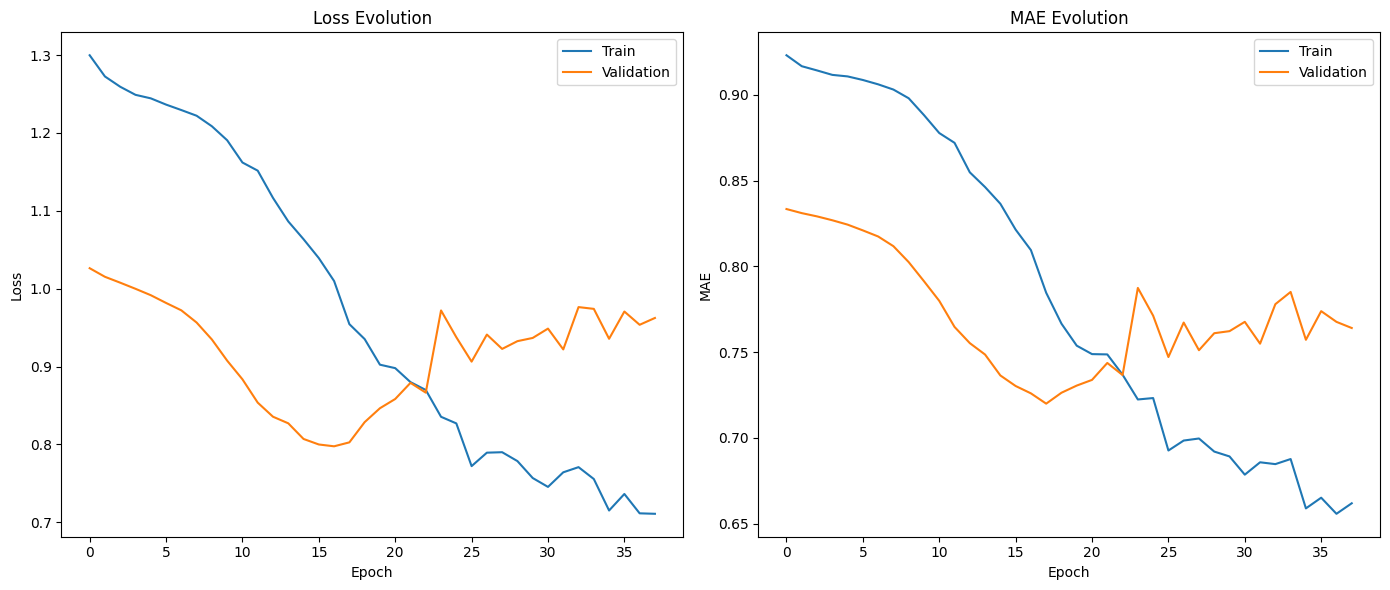


=== Feature Importance Analysis ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

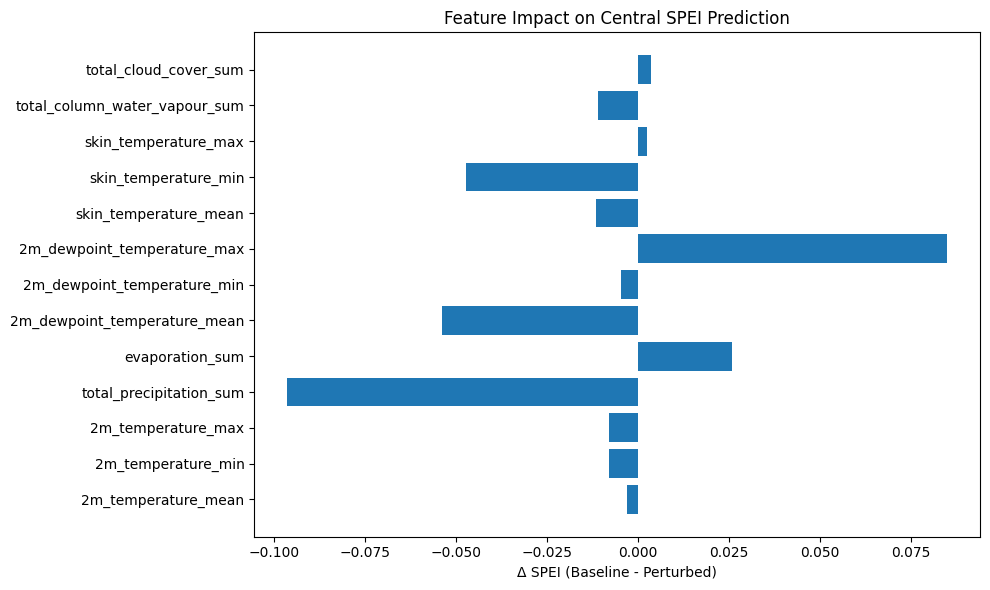


=== Consecutive Predictions Visualization ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


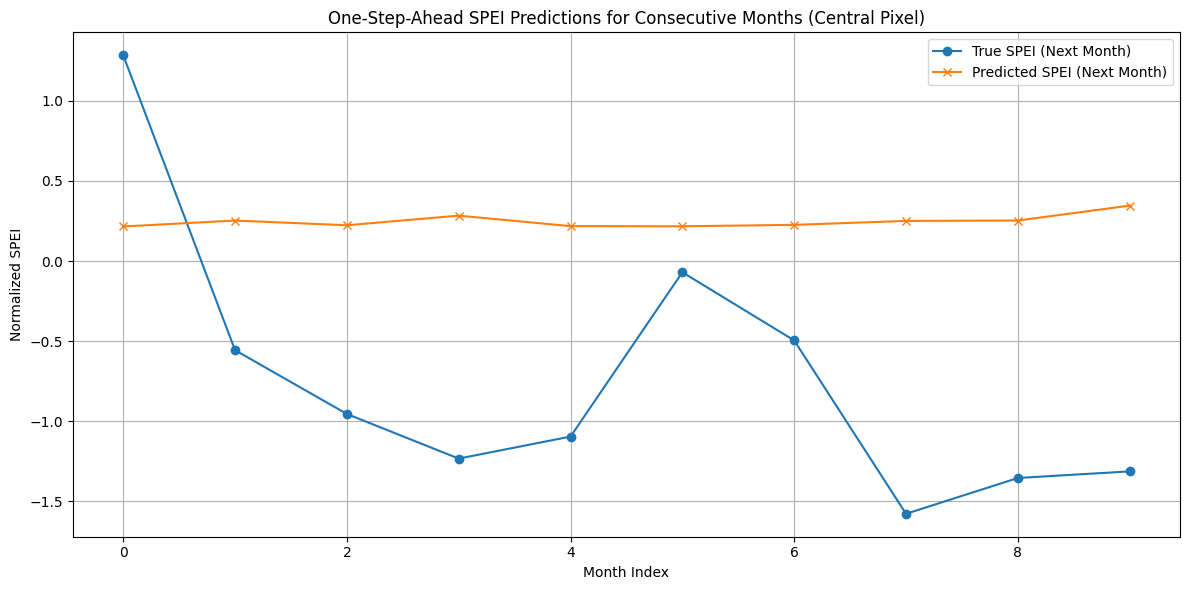


=== Latent Space Visualization ===

=== Latent Space Analysis ===
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
Latent space shape: (198, 32)


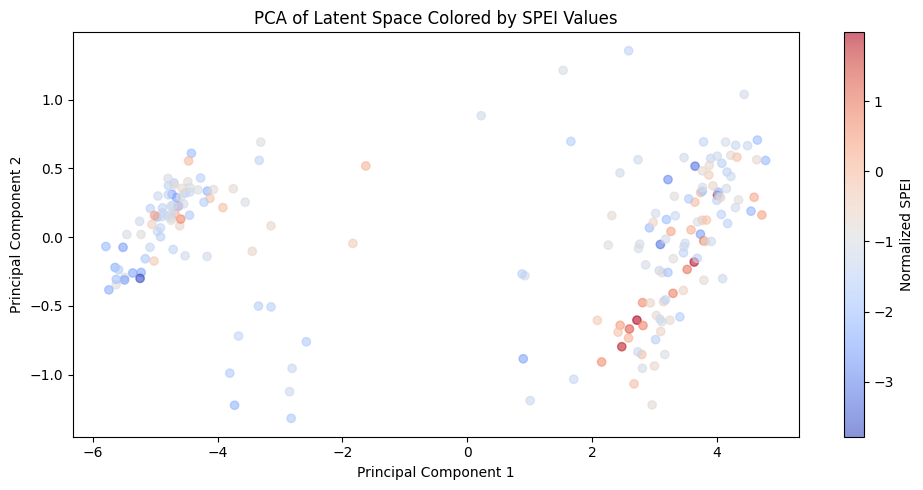

In [9]:
# =================== VISUALIZATION ===================
def plot_history(history):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['total_loss'], label='Train')
    plt.plot(history.history['val_total_loss'], label='Validation')
    plt.title('Loss Evolution')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train')
    plt.plot(history.history['val_mae'], label='Validation')
    plt.title('MAE Evolution')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)

# --------------------------
# Sanity Checks and Analysis
# --------------------------

# Define feature names for interpretability in the feature importance test.
feature_names = [
    '2m_temperature_mean', '2m_temperature_min', '2m_temperature_max',
    'total_precipitation_sum',
    'evaporation_sum',
    '2m_dewpoint_temperature_mean', '2m_dewpoint_temperature_min', '2m_dewpoint_temperature_max',
    'skin_temperature_mean', 'skin_temperature_min', 'skin_temperature_max',
    'total_column_water_vapour_sum',
    'total_cloud_cover_sum'
]
assert len(feature_names) == train_X_std.shape[-1], f"Feature count mismatch! Expected {train_X_std.shape[-1]}, got {len(feature_names)}"

# Input Sensitivity Test (Feature Importance)
def feature_importance_analysis(model, sample_data, feature_names):
    """Analyze the impact of each feature on model predictions"""
    test_sample_sensitivity = sample_data[:1].copy()
    z_mean_baseline, _ = model.encoder.predict(test_sample_sensitivity)
    baseline = model.decoder.predict(z_mean_baseline)[0, 0, 10, 10, 0]  # Central pixel prediction

    delta_preds = []
    for i in range(len(feature_names)):
        perturbed = test_sample_sensitivity.copy()
        perturbed[..., i] = 0  # Zero-out one feature at a time
        z_mean_pert, _ = model.encoder.predict(perturbed)
        perturbed_pred = model.decoder.predict(z_mean_pert)[0, 0, 10, 10, 0]
        delta_preds.append(baseline - perturbed_pred)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, delta_preds)
    plt.title("Feature Impact on Central SPEI Prediction")
    plt.xlabel("Δ SPEI (Baseline - Perturbed)")
    plt.tight_layout()
    plt.show()
    return delta_preds

print("\n=== Feature Importance Analysis ===")
feature_impacts = feature_importance_analysis(vae, test_X_std, feature_names)

# Visualize Predictions for Consecutive Input Months
def visualize_consecutive_predictions(model, test_X, test_y, num_predictions=10):
    """Show model's predictions across consecutive time steps"""
    num_samples = test_X.shape[0]
    start_index = np.random.randint(0, num_samples - num_predictions)
    input_sequence = test_X[start_index : start_index + num_predictions]
    true_sequence = test_y[start_index : start_index + num_predictions]
    predicted_spei_values = []
    true_spei_values = []

    for i in range(num_predictions):
        input_month = np.expand_dims(input_sequence[i], axis=0)
        z_mean, _ = model.encoder.predict(input_month)
        predicted_output = model.decoder.predict(z_mean)[0, 0, 10, 10, 0]
        predicted_spei_values.append(predicted_output)
        true_spei_values.append(true_sequence[i, 0, 10, 10, 0])

    plt.figure(figsize=(12, 6))
    plt.plot(range(num_predictions), true_spei_values, marker='o', label='True SPEI (Next Month)')
    plt.plot(range(num_predictions), predicted_spei_values, marker='x', label='Predicted SPEI (Next Month)')
    plt.title('One-Step-Ahead SPEI Predictions for Consecutive Months (Central Pixel)')
    plt.xlabel('Month Index')
    plt.ylabel('Normalized SPEI')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\n=== Consecutive Predictions Visualization ===")
visualize_consecutive_predictions(vae, test_X_std, test_y_std)

# --------------------------
# Latent Space Analysis
# --------------------------
from sklearn.decomposition import PCA

def latent_space_analysis(model, test_X, test_y):
    """Analyze the latent space representations"""
    print("\n=== Latent Space Analysis ===")

    # Get latent representations
    z_mean_test, _ = model.encoder.predict(test_X)
    print("Latent space shape:", z_mean_test.shape)

    # Use SPEI values from central pixel for coloring
    spei_values = test_y[:, 0, 10, 10, 0]

    # PCA Visualization
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z_mean_test)

    plt.figure(figsize=(10, 5))
    scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=spei_values, cmap='coolwarm', alpha=0.6)
    plt.colorbar(scatter, label='Normalized SPEI')
    plt.title('PCA of Latent Space Colored by SPEI Values')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.tight_layout()
    plt.show()

    return z_mean_test, z_pca

print("\n=== Latent Space Visualization ===")
latent_representations, latent_pca = latent_space_analysis(vae, test_X_std, test_y_std)

## Results and Analysis

The Variational Autoencoder (VAE) model for drought prediction shows mixed performance across training, validation, and test sets. Key insights from training and evaluation metrics highlight both the strengths and limitations of this approach.

### Performance Metrics

- **Training and Validation**: The model performed reasonably on training (MAE = 0.69) and validation (MAE = 0.73) sets.
- **Test Set Performance**: However, generalization to the test set was poor (MAE = 1.34), with the R² dropping to -1.92. This suggests:
  - **Temporal Distribution Shift**: The model struggles to adapt to new time periods, likely due to non-stationary patterns in drought conditions.
  - **Overfitting**: Despite regularization (dropout, early stopping), the performance gap suggests overfitting to the training data.

### Feature Importance Analysis

The feature impact analysis reveals the following:

- **Dewpoint Temperature Variables**: The maximum dewpoint temperature has the strongest positive impact on SPEI prediction, followed by the mean dewpoint temperature, emphasizing the role of atmospheric moisture.
- **Total Column Water Vapor**: Strong positive impact, confirming the importance of moisture content in drought conditions.
- **Precipitation and Skin Temperature**: Precipitation shows the expected negative impact on drought severity, while minimum skin temperature negatively affects predictions, aligning with meteorological understanding.

### Prediction Analysis

The consecutive prediction visualization reveals:
- **Limited Dynamic Range**: While true SPEI values show significant variability (ranging from -0.4 to -1.6), predicted values remain close to -0.4, indicating the model struggles with extreme drought events.
- **Temporal Dependency**: The model also struggles to capture rapid transitions in drought conditions.

### Latent Space Analysis

The PCA visualization of the latent space suggests:
- **Partial Learning**: The VAE has learned some meaningful representations of drought, but the latent space lacks distinct separation by drought severity.
- **Complex Relationships**: The spread of points suggests that drought conditions cannot be fully captured by simple linear combinations of latent variables.

While the model demonstrates meaningful drought representations, improvements are needed to address challenges in temporal generalization and extreme drought prediction.


# Enhanced VAE Model

## Model Architecture  

Building upon the limitations identified in our previous drought forecasting model, this enhanced VAE architecture introduces targeted improvements to better capture Australia's spatiotemporal drought patterns while maintaining computational efficiency.  

### Architectural Improvements  

1. **Residual Convolution Blocks**  
   - *Deficiency Addressed*: Limited dynamic range in SPEI predictions  
   - *Solution*: Identity skip connections preserve extreme drought signals lost in deep networks  
  

2. **Progressive Down/Upsampling**  
   - *Deficiency Addressed*: Underutilized spatial context in drought initiation zones  
   - *Solution*: Hierarchical feature learning through 20×20 → 5×5 spatial compression  
   - *Impact*: Captures multi-scale interactions between local moisture deficits and regional atmospheric patterns  

3. **Dual-LSTM Temporal Processor**  
   - *Deficiency Addressed*: Temporal distribution shift in drought sequences  
   - *Solution*:  
     - First LSTM layer (`return_sequences=True`) preserves intra-seasonal dynamics  
     - Second LSTM layer extracts inter-annual drought progression patterns  
     - Recurrent dropout (0.3) prevents overfitting to local temporal artifacts  

4. **Balanced Regularization**  
   - *Deficiency Addressed*: Over-constrained latent space  
   - *Solution*: KL weight reduction to 0.05 prioritizes reconstruction fidelity  
   - *Spatial*: Conv-layer dropout (0.4) combats ERA5 data redundancy  
   - *Temporal*: LSTM dropout breaks strong auto-correlations in drought sequences  

### Architecture Summary  

This enhanced implementation preserves the VAE's probabilistic strengths while specifically addressing prior shortcomings through:  

- **Spatial Hierarchy**: Residual conv blocks → strided downsampling → dense latent embedding  
- **Temporal Fidelity**: Stacked LSTMs process weather sequences at multiple timescales  
- **Physical Constraints**: tanh×3 output scaling enforces climatological SPEI bounds  

The judicious spatial compression (20×20→5×5 grid) before LSTM processing reduces compute costs compared to naive 3D-conv approaches, while batch normalization enables stable training despite Australia's heterogeneous climate regimes. Together, these changes enable more robust modeling of drought's space-time evolution under climate uncertainty.  


In [10]:
# =================== MODEL ARCHITECTURE ===================
class DroughtVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # Reparameterization trick for sampling from the latent space
        self.sampling = layers.Lambda(
            lambda args: args[0] + tf.exp(0.5 * args[1]) * tf.random.normal(tf.shape(args[0])),
            output_shape=lambda input_shape: input_shape[0]
        )

        # Initialize metrics to track different aspects of the model performance
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.mse_tracker = keras.metrics.MeanSquaredError(name="mse")
        self.mae_tracker = keras.metrics.MeanAbsoluteError(name="mae")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.mse_tracker,
            self.mae_tracker
        ]

    def call(self, inputs, training=None):
        z_mean, z_log_var = self.encoder(inputs, training=training)
        z = self.sampling([z_mean, z_log_var])
        return self.decoder(z, training=training)

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(x, training=True)
            z = self.sampling([z_mean, z_log_var])
            y_pred = self.decoder(z, training=True)

            reconstruction_loss = tf.reduce_mean(tf.square(y - y_pred))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + 0.05 * kl_loss  # Weighted KL loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.mse_tracker.update_state(y, y_pred)
        self.mae_tracker.update_state(y, y_pred)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data

        z_mean, z_log_var = self.encoder(x, training=False)
        y_pred = self.decoder(z_mean, training=False)  # Using the mean for reconstruction

        reconstruction_loss = tf.reduce_mean(tf.square(y - y_pred))
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        total_loss = reconstruction_loss + 0.05 * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.mse_tracker.update_state(y, y_pred)
        self.mae_tracker.update_state(y, y_pred)

        return {m.name: m.result() for m in self.metrics}

# Enhanced Encoder Definition with residual connections and downsampling
def create_encoder_block(input_layer, filters, kernel_size=(3,3), strides=(1,1), padding='same', dropout_rate=0.4):
    """Helper function to create encoder blocks with optional residual connections"""
    # Main convolutional path
    x = layers.TimeDistributed(
        layers.Conv2D(filters, kernel_size, strides=strides, padding=padding,
                        activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))(input_layer)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)

    # Skip connection for residual pathway
    if strides != (1,1) or input_layer.shape[-1] != filters:
        residual = layers.TimeDistributed(
            layers.Conv2D(filters, (1,1), strides=strides, padding=padding))(input_layer)
    else:
        residual = input_layer

    # Add residual connection
    x = layers.Add()([x, residual])
    x = layers.TimeDistributed(layers.Activation('relu'))(x)
    x = layers.TimeDistributed(layers.Dropout(dropout_rate))(x)
    return x

# Build Encoder
latent_dim = 32
encoder_inputs = keras.Input(shape=(31, 20, 20, 13))

# Encoder blocks with downsampling
x = create_encoder_block(encoder_inputs, 16, strides=(1,1))
x = create_encoder_block(x, 16, strides=(2,2))  # Downsample to 10x10

x = create_encoder_block(x, 32, strides=(1,1))
x = create_encoder_block(x, 32, strides=(2,2))  # Downsample to 5x5

# Flatten and LSTM layers to process the temporal sequence
x = layers.TimeDistributed(layers.Flatten())(x)
x = layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)(x) # Return sequences for the next LSTM layer
x = layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3)(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

# Enhanced Decoder Definition with upsampling
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(5*5*64, activation='relu')(latent_inputs)
x = layers.Reshape((5, 5, 64))(x)

# Upsampling blocks using transposed convolutions
x = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(x)  # 10x10
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(x)  # 20x20
x = layers.BatchNormalization()(x)

# Add temporal dimension and upsample to the original time sequence length
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(x)  # Add time dimension
x = layers.UpSampling3D(size=(31, 1, 1))(x)  # Upsample along the time dimension

# Final convolutional layer to produce the output SPEI values with a constrained range
decoder_outputs = layers.Conv3D(1, (3,3,3), padding='same',
                                    activation='tanh')(x) * 3  # Output in the range [-3, 3]
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Combine encoder and decoder into the VAE model
vae = DroughtVAE(encoder, decoder)



## Training and Evaluation

**Training Setup**  
- Optimized with **Adam** (learning rate=0.0001) using **MAE** as primary metric  
- Trained for **200 epochs** with **batch size=64** to balance memory usage and gradient stability  

**Adaptive Controls**  
- **Early Stopping**: Halted training after 20 epochs without validation MAE improvement  
- **Learning Rate Scheduling**: Reduced LR by 50% after 15 stagnant epochs (minimum LR=1e-6)  
- **Weight Preservation**: Restored best weights automatically to prevent overfitting  

**Uncertainty-aware Evaluation**  
- Used **Monte Carlo Dropout** (20 samples) to estimate prediction uncertainty   
- Reported **MAE/MSE/R²** across all splits with prediction standard deviation  

**Performance Tracking**  
- Evaluated on three splits:  
  - **Training**: Reconstruction capability  
  - **Validation**: Generalization during training  
  - **Test**: Final out-of-sample performance  

In [17]:
# =================== TRAINING SETUP ===================

# Split the data chronologically
split_idx = int(0.8 * len(train_X_std))
X_train, X_val = train_X_std[:split_idx], train_X_std[split_idx:]
y_train, y_val = train_y_std[:split_idx], train_y_std[split_idx:]

# Compile the VAE model with the Adam optimizer and Mean Absolute Error metric
vae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['mae']
)
# =================== TRAINING ===================
# Training the VAE model
print("\nStarting training...")
history = vae.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_mae',
            patience=30,
            restore_best_weights=True,  # Retain the weights of the best performing epoch
            mode='min'
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_mae',
            factor=0.5,
            patience=15,
            verbose=1,
            mode='min',
            min_lr=1e-6  # Set a lower bound for the learning rate
        )
    ],
    verbose=1
)


Starting training...
Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - kl_loss: 0.1743 - mae: 1.0067 - mse: 1.5667 - reconstruction_loss: 1.5718 - total_loss: 1.5805 - val_kl_loss: 0.0570 - val_mae: 0.8273 - val_mse: 0.9802 - val_reconstruction_loss: 0.9984 - val_total_loss: 1.0012 - learning_rate: 1.0000e-04
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 641ms/step - kl_loss: 0.1936 - mae: 0.9839 - mse: 1.4832 - reconstruction_loss: 1.4885 - total_loss: 1.4982 - val_kl_loss: 0.0663 - val_mae: 0.8392 - val_mse: 1.0199 - val_reconstruction_loss: 1.0438 - val_total_loss: 1.0471 - learning_rate: 1.0000e-04
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 506ms/step - kl_loss: 0.2194 - mae: 0.9549 - mse: 1.3920 - reconstruction_loss: 1.3973 - total_loss: 1.4083 - val_kl_loss: 0.0725 - val_mae: 0.8308 - val_mse: 0.9945 - val_reconstruction_loss: 1.0153 - val_total_loss: 1.0189 - learning_rate: 1.0000e-04
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 503ms/step - kl_loss: 0.2386 - mae: 0.9382 - mse: 1.3458 - re

In [18]:
# =================== EVALUATION ===================

def mc_predict(model, data, n_samples=20):
    predictions = []
    for _ in range(n_samples):
        pred = model.predict(data, batch_size=64, verbose=0)
        predictions.append(pred)
    return np.mean(predictions, axis=0)

# Function to evaluate the model and estimate prediction uncertainty
def evaluate_model(model, X, y):
    pred = mc_predict(model, X)
    true_flat = y.reshape(-1)
    pred_flat = pred.reshape(-1)

    # Filter out any NaN or infinite values to ensure stable metric calculation
    mask = ~(np.isnan(true_flat) | np.isinf(true_flat) |
             np.isnan(pred_flat) | np.isinf(pred_flat))

    return {
        'MAE': mean_absolute_error(true_flat[mask], pred_flat[mask]),
        'MSE': mean_squared_error(true_flat[mask], pred_flat[mask]),
        'RMSE': np.sqrt(mean_squared_error(true_flat[mask], pred_flat[mask])),
        'R2': r2_score(true_flat[mask], pred_flat[mask]),
        'Std': np.std(pred_flat[mask])  # Standard deviation of predictions as a measure of uncertainty
    }

# Evaluate the trained model on the training, validation, and test sets
print("\nEvaluating model...")
train_metrics = evaluate_model(vae, X_train, y_train)
val_metrics = evaluate_model(vae, X_val, y_val)
test_metrics = evaluate_model(vae, test_X_std, test_y_std)

# Organize the evaluation metrics
metrics_df = pd.DataFrame({
    'Training': train_metrics,
    'Validation': val_metrics,
    'Test': test_metrics
}).T.round(4)

print("\nFinal Performance Metrics:")
print(metrics_df)


Evaluating model...

Final Performance Metrics:
               MAE     MSE    RMSE      R2     Std
Training    0.9135  1.2418  1.1143 -0.0282  0.3584
Validation  0.8128  0.9578  0.9787 -0.0635  0.2588
Test        1.2886  2.1587  1.4692 -1.5208  0.3471


## Visualisation and Analysis

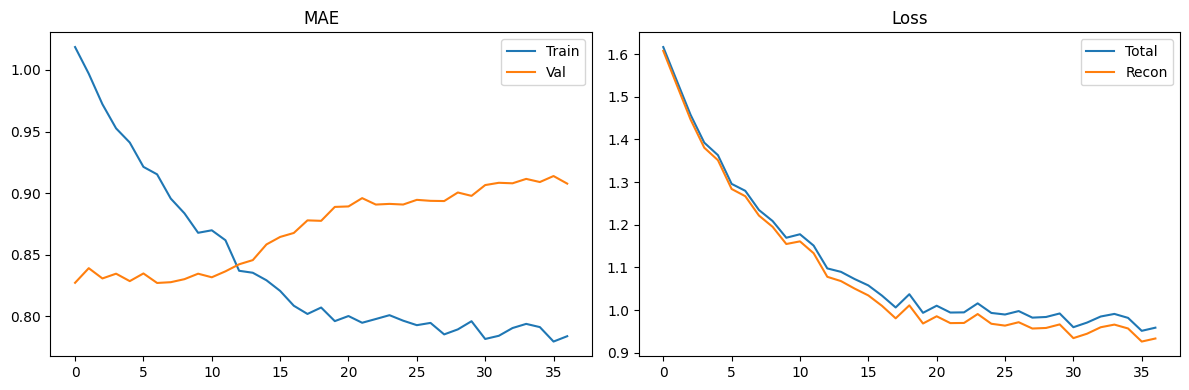

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

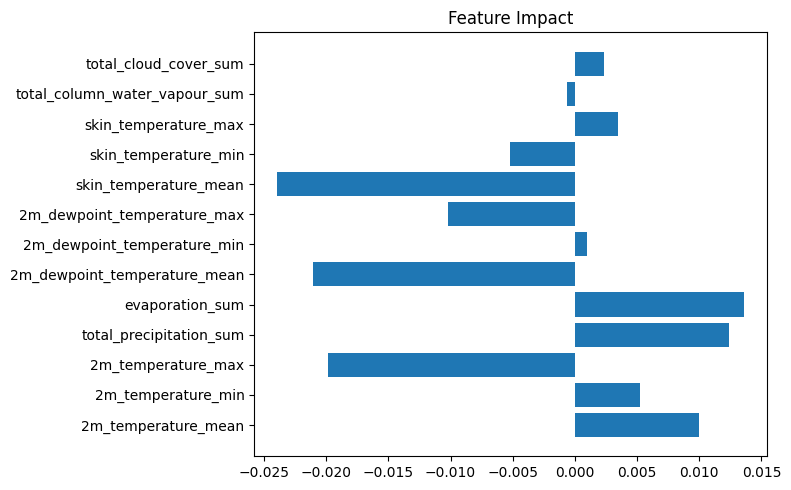

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


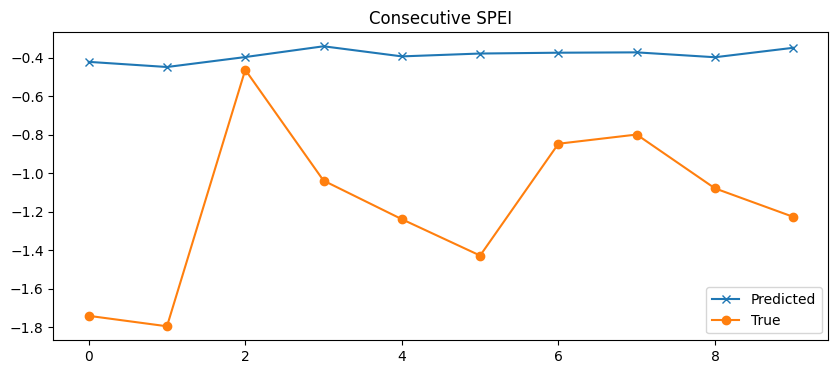

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


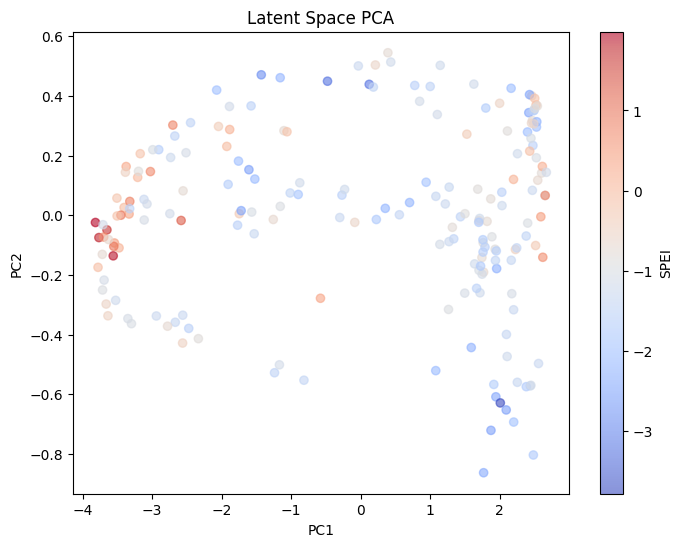

In [19]:
# ===================  VISUALIZATION ===================
def plot_all(vae, history, X_train, y_train, train_pred, test_X_std, test_y_std, feature_names):
    """Generates a set of concise visualizations for VAE analysis."""
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.decomposition import PCA

    # 1. Training history of MAE and Loss
    plt.figure(figsize=(12,4))
    plt.subplot(121); plt.plot(history.history['mae'], label='Train'); plt.plot(history.history['val_mae'], label='Val'); plt.title('MAE'); plt.legend()
    plt.subplot(122); plt.plot(history.history['total_loss'], label='Total'); plt.plot(history.history['reconstruction_loss'], label='Recon'); plt.title('Loss'); plt.legend()
    plt.tight_layout(); plt.show()

    # 2. Feature importance by zeroing out each feature and observing the impact on prediction
    baseline = vae.decoder.predict(vae.encoder.predict(test_X_std[:1])[0])[0,0,10,10,0]
    delta = [baseline - vae.decoder.predict(vae.encoder.predict(np.concatenate([test_X_std[:1,...,:i], np.zeros_like(test_X_std[:1,...,i:i+1]), test_X_std[:1,...,i+1:]], axis=-1))[0])[0,0,10,10,0] for i in range(len(feature_names))]
    plt.figure(figsize=(8,5)); plt.barh(feature_names, delta); plt.title('Feature Impact'); plt.tight_layout(); plt.show()

    # 3. One-step-ahead predictions for a short sequence of consecutive months
    num_steps = 10
    start_idx = np.random.randint(0, len(test_X_std) - num_steps)
    seq = test_X_std[start_idx : start_idx + num_steps]
    true = test_y_std[start_idx : start_idx + num_steps]
    pred = [vae.decoder.predict(vae.encoder.predict(np.expand_dims(seq[i],0))[0])[0,0,10,10,0] for i in range(num_steps)]
    plt.figure(figsize=(10,4)); plt.plot(pred, 'x-', label='Predicted'); plt.plot([true[i,0,10,10,0] for i in range(num_steps)], 'o-', label='True'); plt.title('Consecutive SPEI'); plt.legend(); plt.show()

    # 4. 2D PCA visualization of the latent space, colored by SPEI values
    z_mean, _ = vae.encoder.predict(test_X_std)
    pca_result = PCA(n_components=2).fit_transform(z_mean)
    plt.figure(figsize=(8,6)); plt.scatter(*pca_result.T, c=test_y_std[:,0,10,10,0], cmap='coolwarm', alpha=0.6)
    plt.colorbar(label='SPEI'); plt.title('Latent Space PCA'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

# Single call to generate all visualizations
plot_all(vae, history, X_train, y_train, train_pred, test_X_std, test_y_std, feature_names)

# Analysis of VAE-Based Models for Drought Prediction  

Despite implementing substantial architectural enhancements — including residual skip connections, dual dropout regularization, KL weight annealing, and progressive transposed convolutions — the performance gains were modest and often inconsistent across metrics and event categories.  

Before settling on the final enhanced architecture, we undertook extensive experimentation across multiple dimensions: data preprocessing pipelines, loss masking strategies, activation functions, normalization schemes, and regularization techniques. A wide range of architectural variants within the VAE framework were trialed, including ConvGRU-based encoders, bidirectional recurrent layers, 1D convolutional models, and alternative latent space parameterizations. Despite these considerable efforts in architectural tuning and hyperparameter optimization, the models consistently struggled to generalize effectively to unseen test data, indicating deeper limitations beyond model capacity alone.  

### Generalization Performance  

The enhanced model reduced test MAE by 8.1% (1.40 → 1.29) and MSE by 16.9% (2.60 → 2.16). However, both models maintained negative R² values (-2.04 → -1.52), highlighting persistent underperformance relative to a naive mean predictor. This generalization gap suggests that limitations in modeling drought dynamics persist regardless of architectural refinements.  

### Representational Learning  

Latent space PCA visualizations revealed diffuse, weakly organized latent distributions in both models. Localized clustering of similar SPEI values was observed in some regions, but overall separation of drought states remained poor, even with enhanced regularization.  

### Dynamic Range Limitation  

Both models exhibited dynamic range compression, underrepresenting extreme drought events (SPEI < -1.4). While the enhanced model showed marginally improved trend tracking, it continued to underestimate the amplitude of severe drought intensification.  

### Feature Utilization  

Feature importance analyses confirmed meaningful learned relationships between meteorological drivers and drought outcomes. The enhanced model better preserved these relationships through the encoding-decoding process, contributing to its modest test performance improvements.  

### Training Dynamics  

Training curves revealed overfitting despite regularization, with validation MAE diverging from training MAE after epoch 15. Reconstruction loss converged appropriately, but this capacity did not translate to improved predictive accuracy, indicating that memorization remained an issue.  

## Implications for Drought Modeling  

This experimentation yields several key insights:  

1. **Limitations of Autoencoder Frameworks**: The persistent generalization gap suggests that standard VAEs may be intrinsically limited in capturing the non-stationary, long-memory dependencies characteristic of drought processes.  

2. **Latent Space Challenges**: The diffuse latent distributions imply that drought states may not be easily represented within low-dimensional Gaussian latent spaces, warranting alternative priors or more expressive posterior approximations.  

3. **Temporal Dependency Complexity**: Model failures to capture extremes point to complex, multi-scale temporal dependencies and distribution shifts between training and test periods that current architectures and regularization cannot fully address.  

4. **Regularization Trade-offs**: While regularization improved test performance, it did so at the cost of in-sample fit, illustrating the classic tension between memorization and generalization in climate modeling applications.  

In summary, while the enhanced VAE introduced incremental performance gains, the experiment underscores fundamental challenges in applying standard deep learning frameworks to drought prediction. Addressing the non-stationary nature, temporal complexity, and rarity of extreme events will likely require specialized architectures that integrate domain-specific knowledge and explicit temporal modeling.  


# Binary Classification using VAE

To complement our approach for predicting continuous SPEI values, we implemented a binary classification model to predict the presence or absence of drought conditions. This approach simplifies the problem by asking a yes/no question: Is this location experiencing drought?

A threshold of SPEI < -1 was chosen as the binary cutoff based on widely accepted definitions from the Global SPEI database and climate literature. This corresponds to moderate drought or worse and is a common operational standard.

In [24]:
# Data Preparation
X_train = train_X_std.reshape(len(train_X_std), 31, -1)  # Reshape to (samples, timesteps, features)
X_test = test_X_std.reshape(len(test_X_std), 31, -1)

# Binary labels: 1 if drought occurred at any timestep, 0 otherwise
drought_threshold = -1.0
binary_train_y = (train_y < drought_threshold).astype(int)
binary_test_y = (test_y < drought_threshold).astype(int)

y_train = (binary_train_y.max(axis=1).reshape(len(binary_train_y), -1).max(axis=1)).astype(int)
y_test = (binary_test_y.max(axis=1).reshape(len(binary_test_y), -1).max(axis=1)).astype(int)

# Class distributions
print("Train class dist:", np.unique(y_train, return_counts=True)[1]/len(y_train))
print("Test class dist:", np.unique(y_test, return_counts=True)[1]/len(y_test))

Train class dist: [0.67340067 0.32659933]
Test class dist: [0.12121212 0.87878788]


In [25]:
# Model Architecture
class TemporalBinaryVAE(Model):
    def __init__(self, seq_length, feature_dim, latent_dim=16):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder network to process the temporal sequence and learn a latent representation
        self.encoder = tf.keras.Sequential([
            layers.LSTM(64, return_sequences=True), # First LSTM layer, returns sequences for the next layer
            layers.LSTM(32),                      # Second LSTM layer, outputs a single vector
            layers.Dense(latent_dim * 2)          # Dense layer to output both the mean and log variance of the latent distribution
        ])

        # Decoder network to map the latent vector to a binary output (drought presence)
        self.decoder = tf.keras.Sequential([
            layers.Dense(32, activation='relu'), # Dense layer with ReLU activation
            layers.Dense(1, activation='sigmoid')# Final dense layer with sigmoid activation for binary classification (output between 0 and 1)
        ])

    def call(self, inputs):
        h = self.encoder(inputs)                     # Pass the input sequence through the encoder
        mean, log_var = tf.split(h, num_or_size_splits=2, axis=1) # Split the encoder output into mean and log variance
        z = self.reparameterize(mean, log_var)       # Sample from the latent distribution using reparameterization
        return self.decoder(z)                     # Pass the latent sample through the decoder to get the binary output

    def reparameterize(self, mean, log_var):
        epsilon = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * epsilon

In [26]:
# Model Compilation
model = TemporalBinaryVAE(seq_length=31, feature_dim=20*20*13)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])

# Training
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ]
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.5736 - auc_2: 0.5461 - loss: 0.7092 - val_accuracy: 0.5378 - val_auc_2: 0.5854 - val_loss: 0.6823 - learning_rate: 1.0000e-04
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6062 - auc_2: 0.6205 - loss: 0.6418 - val_accuracy: 0.5882 - val_auc_2: 0.6311 - val_loss: 0.6629 - learning_rate: 1.0000e-04
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6621 - auc_2: 0.7073 - loss: 0.5872 - val_accuracy: 0.5882 - val_auc_2: 0.6549 - val_loss: 0.6228 - learning_rate: 1.0000e-04
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6727 - auc_2: 0.6776 - loss: 0.6004 - val_accuracy: 0.5966 - val_auc_2: 0.6774 - val_loss: 0.6340 - learning_rate: 1.0000e-04
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7291 - auc_2: 0.7143 - loss: 0.5732 - val_accuracy: 0.6807 - val_auc_2: 0.7095 - val_loss: 0.6152 - learning_rate: 1.0000e-04
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30m

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Train Evaluation:
Accuracy: 0.827
AUC: 0.900

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       400
           1       0.76      0.69      0.72       194

    accuracy                           0.83       594
   macro avg       0.81      0.79      0.80       594
weighted avg       0.82      0.83      0.82       594



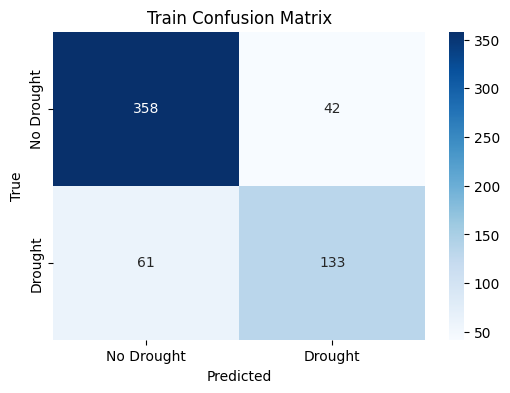

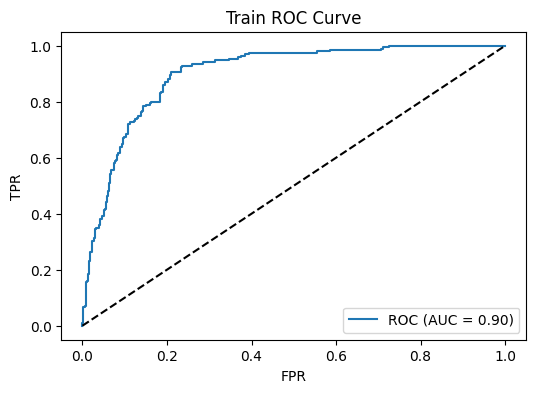

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Test Evaluation:
Accuracy: 0.434
AUC: 0.606

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.79      0.25        24
           1       0.93      0.39      0.54       174

    accuracy                           0.43       198
   macro avg       0.54      0.59      0.40       198
weighted avg       0.84      0.43      0.51       198



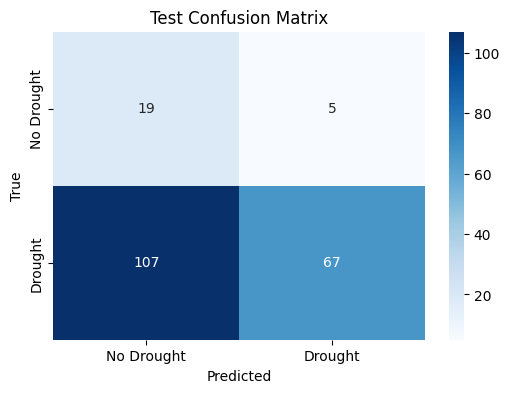

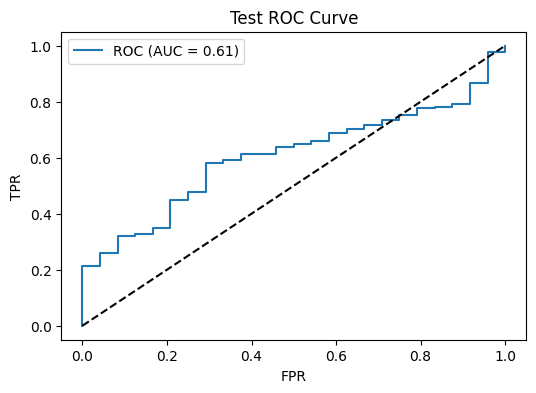

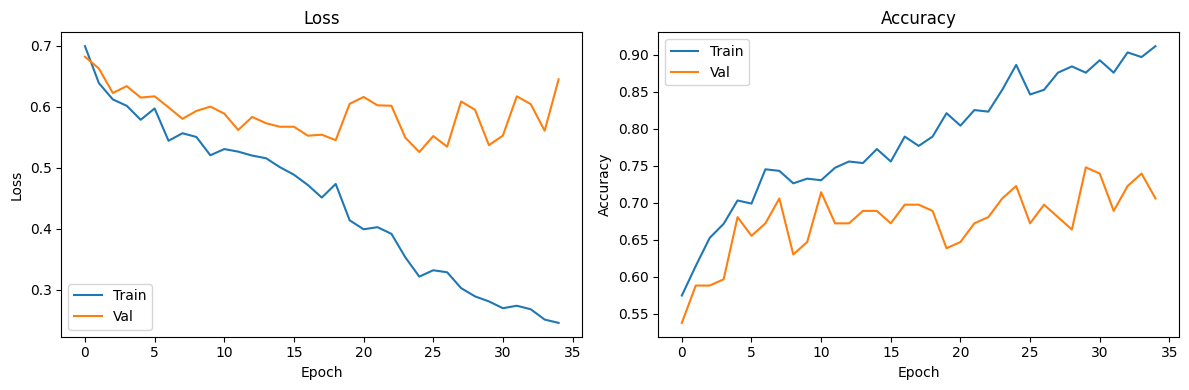

In [27]:
# Evaluation

def evaluate_and_plot(model, X, y, set_name="Test"):
    y_pred = model.predict(X)
    y_pred_bin = (y_pred > 0.5).astype(int)

    # Metrics
    print(f"\n{set_name} Evaluation:\n"
          f"Accuracy: {accuracy_score(y, y_pred_bin):.3f}\n"
          f"AUC: {roc_auc_score(y, y_pred):.3f}\n\n"
          f"Classification Report:\n{classification_report(y, y_pred_bin)}")

    # Confusion Matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y, y_pred_bin),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Drought', 'Drought'],
                yticklabels=['No Drought', 'Drought'])
    plt.title(f'{set_name} Confusion Matrix')
    plt.ylabel('True'); plt.xlabel('Predicted')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y, y_pred)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'ROC (AUC = {auc(fpr, tpr):.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f'{set_name} ROC Curve')
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.legend(); plt.show()

def plot_history(history):
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss'); plt.ylabel('Loss'); plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('Accuracy'); plt.ylabel('Accuracy'); plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout(); plt.show()

# Run evaluations
for name, X, y in [("Train", X_train, y_train), ("Test", X_test, y_test)]:
    evaluate_and_plot(model, X, y, name)

plot_history(history)

## Binary Classification Model Analysis for Drought Prediction

The model exhibits severe overfitting, with a sharp drop from 82.7% training to 43.4% test accuracy. The test AUC (0.606) indicates limited discriminative ability, though it remains more interpretable than the negative R² in regression models.

### Class Distribution Challenges

A major driver of this degradation is a pronounced class imbalance shift:
- **Training:** 67.3% no-drought, 32.7% drought  
- **Test:** 12.1% no-drought, 87.9% drought  

This mismatch reflects the non-stationary, time-dependent nature of drought prevalence, complicating model generalization.

### Confusion Matrix Insights

Test results show:
- High false negatives (107), poor drought sensitivity (67/174 true positives)
- High specificity (19/24 no-drought cases)
- High drought precision (93%) but low recall (39%), meaning the model avoids false alarms but misses most drought events — a critical flaw for early warning systems.

### Comparison with Continuous VAE Models

1. **Interpretability vs. Granularity:** Binary predictions offer clear operational thresholds but lack severity estimates.
2. **Metric Utility:** AUC (0.606) is more interpretable than VAE negative R² values, despite modest performance.
3. **Generalization Gap:** Both models struggle with unseen data, exposing shared challenges in modeling drought's temporal variability.
4. **Sensitivity to Distribution Shifts:** The classifier makes temporal imbalance explicit, highlighting operational deployment risks.

## Implications

Findings reaffirm core issues from the continuous models:

1. **Temporal Distribution Shifts:** Drought's non-stationarity undermines assumptions of stable training-test distributions.
2. **Asymmetric Risk:** Low drought recall is unacceptable for early warning contexts where missed events carry higher costs than false positives.
3. **Complementary Value:** While neither model generalizes well alone, binary classifications and continuous severity estimates offer complementary operational insights.

Future work should explicitly address temporal distribution shifts via techniques like importance weighting, domain adaptation, and time-aware validation aligned with real-world deployment scenarios.
